In [1]:
!pip install biopython

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 3.1 MB 2.5 MB/s            


In [9]:
from Bio import SeqIO
from Bio.Data import CodonTable
import pandas as pd

In [11]:
## 1 ##This function could extract sequences from a FASTA file and store them in a dictionary with their species names as keys.The species name is extracted from the description line of the FASTA file, assuming it is located at the second and third positions of the description line when split by whitespace.
def get_sequences_from_file(fasta_fn):
    sequence_data_dict = {}
    for record in SeqIO.parse(fasta_fn, "fasta"):
        description = record.description.split()
        species_name = description[1] + " " + description[2]
        sequence_data_dict[species_name] = record.seq
    return(sequence_data_dict)

In [12]:
## 2 ## translates a string of nucleotides into amino acids according to the Vertebrate Mitochondrial codon table
from Bio.Data import CodonTable
def translate_function(string_nucleotides):
    mito_table = CodonTable.unambiguous_dna_by_name["Vertebrate Mitochondrial"]
    aa_seq_string = ""
    for i in range(0, len(string_nucleotides), 3):
        codon = string_nucleotides[i:i+3]
        # Stop translating if we hit a stop codon or if the sequence length isn't a multiple of 3
        if codon in mito_table.stop_codons or len(codon) != 3:
            break
        aa = mito_table.forward_table.get(codon, '')  # Safely get the amino acid or return an empty string
        aa_seq_string += aa

    return aa_seq_string

In [13]:
## 3 ## Alternative function
from Bio.Seq import Seq
def translate_sequence(dna_seq):
    dna_sequence = Seq(dna_seq)
    amino_acid_sequence = dna_sequence.translate(to_stop=True, table="Vertebrate Mitochondrial")
    return str(amino_acid_sequence)

In [14]:
## 4 ## Amino Acid analysis function
from Bio.SeqUtils.ProtParam import ProteinAnalysis
def compute_molecular_weight(aa_seq):
    analyzed_seq = ProteinAnalysis(aa_seq)
    mol_weight = analyzed_seq.molecular_weight() 
    return mol_weight

In [15]:
## 5 ##
####### GC CONTENT ANALYSIS FUNCTION ########
def calculate_gc_content(seq):
    cleaned_seq = seq.replace(" ", "").replace("\n", "")
    gc_count = cleaned_seq.count('G') + cleaned_seq.count('C')
    gc_content = (gc_count / len(cleaned_seq)) * 10  
    return gc_content

In [16]:
## Import data
cytb_seqs = get_sequences_from_file("penguins_cytb.fasta") 

penguins_df = pd.read_csv("penguins_mass.csv") # Includes only data for body mass 
species_list = list(penguins_df.species)
penguins_df

,species,mass
0,Aptenodytes forsteri,28.00
1,Aptenodytes patagonicus,13.40
2,Eudyptes chrysocome,2.80
3,Eudyptes chrysolophus,4.50
4,Eudyptes sclateri,4.25
5,Eudyptula minor,1.60
6,Pygoscelis adeliae,4.60
7,Pygoscelis antarctica,4.10
8,Pygoscelis papua,6.10
9,Spheniscus demersus,3.20


In [17]:
## 6-7 ##
penguins_df['molecular_weight'] = pd.NA
penguins_df['GC_content'] = pd.NA
for index, row in penguins_df.iterrows():
    species = row['species']
    if species in cytb_seqs:
        seq = cytb_seqs[species]
        gc_content = calculate_gc_content(seq)
        penguins_df.at[index, 'GC_content'] = gc_content
    else:
        print(f"Sequence not found for {species}")
for species, seq in cytb_seqs.items():
    seq_str = str(seq).replace('*', '')
    mw = compute_molecular_weight(seq_str)
    index = penguins_df.index[penguins_df['species'] == species].tolist()[0]
    penguins_df.at[index, 'molecular_weight'] = mw

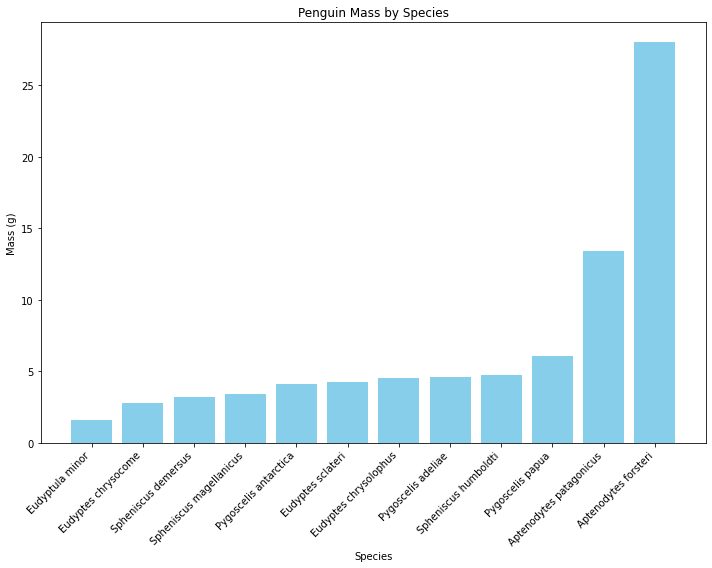

In [18]:
##8##
import matplotlib.pyplot as plt
def plot_penguin_mass(df):
    # Sort the DataFrame by the 'mass' column to answer Q1 visually
    sorted_df = df.sort_values('mass', ascending=True)  
    plt.figure(figsize=(10, 8))
    plt.bar(sorted_df['species'], sorted_df['mass'], color='skyblue')
    plt.xlabel('Species')
    plt.ylabel('Mass (g)')
    plt.xticks(rotation=45, ha='right')  # Rotate species names for better readability
    plt.title('Penguin Mass by Species')
    plt.tight_layout()  # Adjust layout to fit species names
    plt.show()
plot_penguin_mass(penguins_df)

In [19]:
## 8.q1 ##
smallest_species_row = penguins_df.iloc[penguins_df['mass'].idxmin()]
smallest_species = smallest_species_row['species']
print(f"The smallest penguin species is: {smallest_species}")
## The smallest penguin species is: Eudyptula minor
## 8.q2 ##
# Mostly, the penguin lives in: Antarctica, New Zealand, southern Australia, Tasmania, South American

The smallest penguin species is: Eudyptula minor


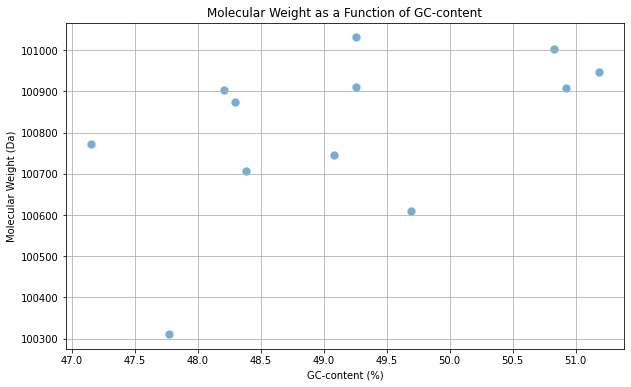

In [18]:
## 9 ##
penguins_df['molecular_weight'] = penguins_df['molecular_weight'].astype(float)
penguins_df['GC_content'] = penguins_df['GC_content'].astype(float)
plt.figure(figsize=(10, 6))
plt.scatter(penguins_df['GC_content'], penguins_df['molecular_weight'], alpha=0.6, edgecolors='w', s=80)
plt.title('Molecular Weight as a Function of GC-content')
plt.xlabel('GC-content (%)')
plt.ylabel('Molecular Weight (Da)')
plt.grid(True)
plt.show()

In [19]:
## 10 ## save the file
penguins_df.to_csv("penguins_mass_cytb.csv", index=False)

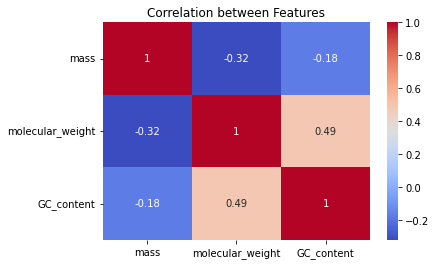

In [30]:
## 11 ## 
##11.1 A correlation analysis between different numerical features like body mass, molecular weight, and GC content. This could help uncover relationships between genetic characteristics and physical traits.
import seaborn as sns
import matplotlib.pyplot as plt
def plot_correlations(df):
    correlation_matrix = df[['mass', 'molecular_weight', 'GC_content']].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
    plt.title('Correlation between Features')
    plt.show()
plot_correlations(penguins_df)

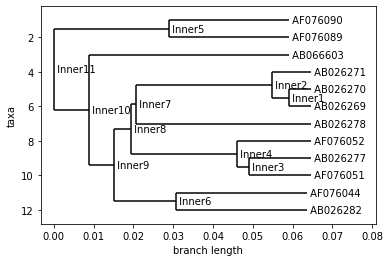

In [33]:
## 11.2  construct a phylogenetic tree to explore the evolutionary relationships between the species.
from Bio.Phylo.TreeConstruction import DistanceCalculator, DistanceTreeConstructor
from Bio import AlignIO

def build_phylogenetic_tree(fasta_file):
    alignment = AlignIO.read(fasta_file, 'fasta')
    calculator = DistanceCalculator('identity')
    distance_matrix = calculator.get_distance(alignment)
    constructor = DistanceTreeConstructor()
    tree = constructor.upgma(distance_matrix)
    
    # Plotting the tree
    from Bio.Phylo import draw
    draw(tree)
build_phylogenetic_tree("penguins_cytb.fasta")